<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/5_Cross_sectional_analysis_of_Cryptocurrencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-sectional analysis of Cryptocurrencies

## Get Data


In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', 'roll'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp0TPS3k/remotes8673ec52e3/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp0TPS3k/remotes867295abac/Robot-Wealth-rsims-2589683/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded director

In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
head(prices)

Authorization successful!

Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


ℹ Downloading coinmetrics.csv

✔ Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


# Remove Stablecoins from our dataset

We want to do cross-sectional returns analysis on things that move.

In [3]:
# snippet: rw crypto remove stablecoins v0.1
# Remove stablecoins from data set
prices <- prices %>% 
  filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX'))

## Calculate simple and log returns

In [4]:
# snippet: rw crypto calc periodic returns v.0.1
# Calculate log and simple returns at the same periodicity as your data.
# Assumes there are no gaps in your data and your price column is price_usd (as it is in default coinmetrics data) 
returns <- prices %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(log_return = log(price_usd / lag(price_usd, n = 1))) %>%
  mutate(simple_return = price_usd / lag(price_usd, n = 1) - 1) %>%
  na.omit() %>%
  ungroup()

head(returns)

ticker,date,price_usd,market_cap,log_return,simple_return
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-07-19,0.08080000,279285.2,-0.06050813,-0.05871389
BTC,2010-07-20,0.07473573,259000.4,-0.07801869,-0.07505286
BTC,2010-07-21,0.07919286,275266.5,0.05792790,0.05963859
BTC,2010-07-22,0.05846976,203749.6,-0.30337647,-0.26167891
BTC,2010-07-23,0.06059287,211735.7,0.03566752,0.03631124
BTC,2010-07-24,0.05454000,191100.0,-0.10524285,-0.09989409


## Creating an index to analyze

Let's perform our analysis on the top 10 coins by marketcap. 

First, we'll see how many coins we have in our dataset, by date.

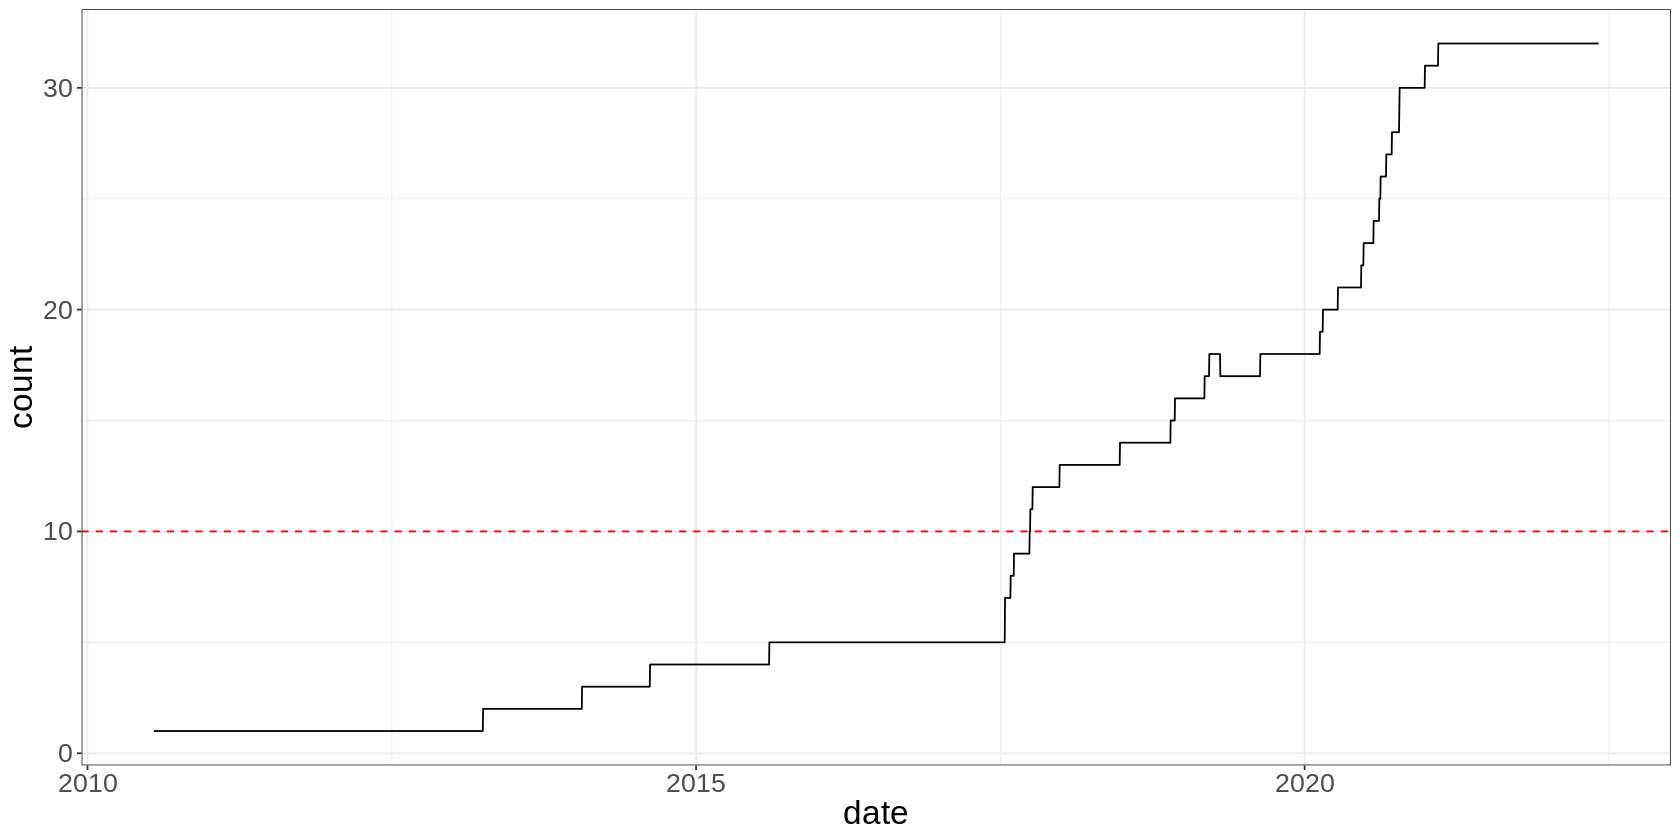

In [5]:
returns %>%
  group_by(date) %>%
  summarise(count = n()) %>%
  ggplot(aes(x=date, y = count)) + geom_line() + geom_hline(yintercept = 10, linetype = 'dashed', color = 'red')

It seems reasonable to start our analysis in early 2015, when we have 10 assets in our universe.


In [6]:
returns %>%
  group_by(date) %>%
  summarise(count = n()) %>%
  filter(count >= 10) %>%
  summarise(min(date))

min(date)
<date>
2017-09-28


For a given ticker/date observation, set is_index to TRUE if:
 - the asset was in the top 10 coins by market cap the day before
 - the date is on or after 2015-04-02 (when our analysis universe starts)

In [7]:
universe <- returns %>%
  group_by(date) %>%
  mutate(cap_rank = row_number(desc(market_cap))) %>%
  arrange(date) %>%
  group_by(ticker) %>%
  mutate(is_index = lag(cap_rank) <= 10 & date >= '2015-04-02') %>%
  na.omit()

universe %>% head()
universe %>% tail()

ticker,date,price_usd,market_cap,log_return,simple_return,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2010-07-19,0.08080000,279285.2,-0.06050813,-0.05871389,1,FALSE
BTC,2010-07-20,0.07473573,259000.4,-0.07801869,-0.07505286,1,FALSE
BTC,2010-07-21,0.07919286,275266.5,0.05792790,0.05963859,1,FALSE
BTC,2010-07-22,0.05846976,203749.6,-0.30337647,-0.26167891,1,FALSE
BTC,2010-07-23,0.06059287,211735.7,0.03566752,0.03631124,1,FALSE
BTC,2010-07-24,0.05454000,191100.0,-0.10524285,-0.09989409,1,FALSE


ticker,date,price_usd,market_cap,log_return,simple_return,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
UNI,2022-06-01,5.168436e+00,5168436074,-0.0992629487,-0.0944954245,10,TRUE
WBTC,2022-06-01,2.982592e+04,8163411274,-0.0650756354,-0.0630034094,8,TRUE
XAUT,2022-06-01,1.844468e+03,157549573,0.0009190113,0.0009194337,29,FALSE
XRP,2022-06-01,3.983263e-01,39828407681,-0.0601053112,-0.0583346396,3,TRUE
YFI,2022-06-01,7.552570e+03,276922547,-0.0680020446,-0.0657414366,26,FALSE
ZRX,2022-06-01,4.001723e-01,400172270,-0.0503324306,-0.0490867407,22,FALSE


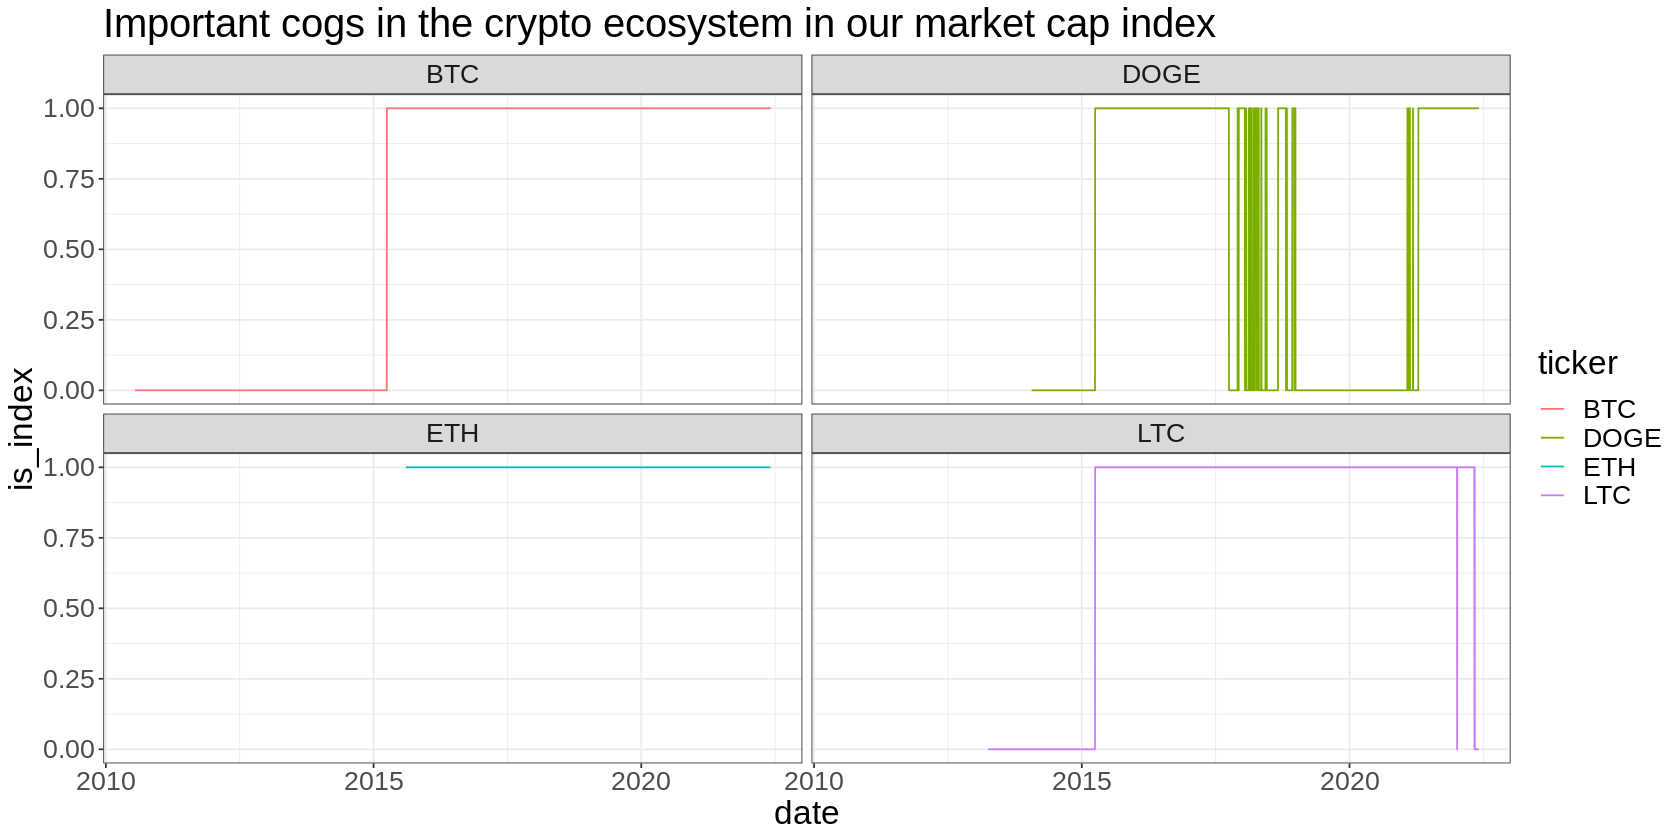

In [8]:
universe %>%
  filter(ticker %in% c("DOGE", "BTC", "LTC", "ETH")) %>%
  mutate(is_index = case_when(is_index == TRUE ~ 1, TRUE ~ 0)) %>%
  ggplot(aes(x = date, y = is_index, colour = ticker)) +
    geom_line() +
    facet_wrap(~ticker) +
    labs(
      title = "Important cogs in the crypto ecosystem in our market cap index"
    )

What do the returns look like for equal weighting into that universe?

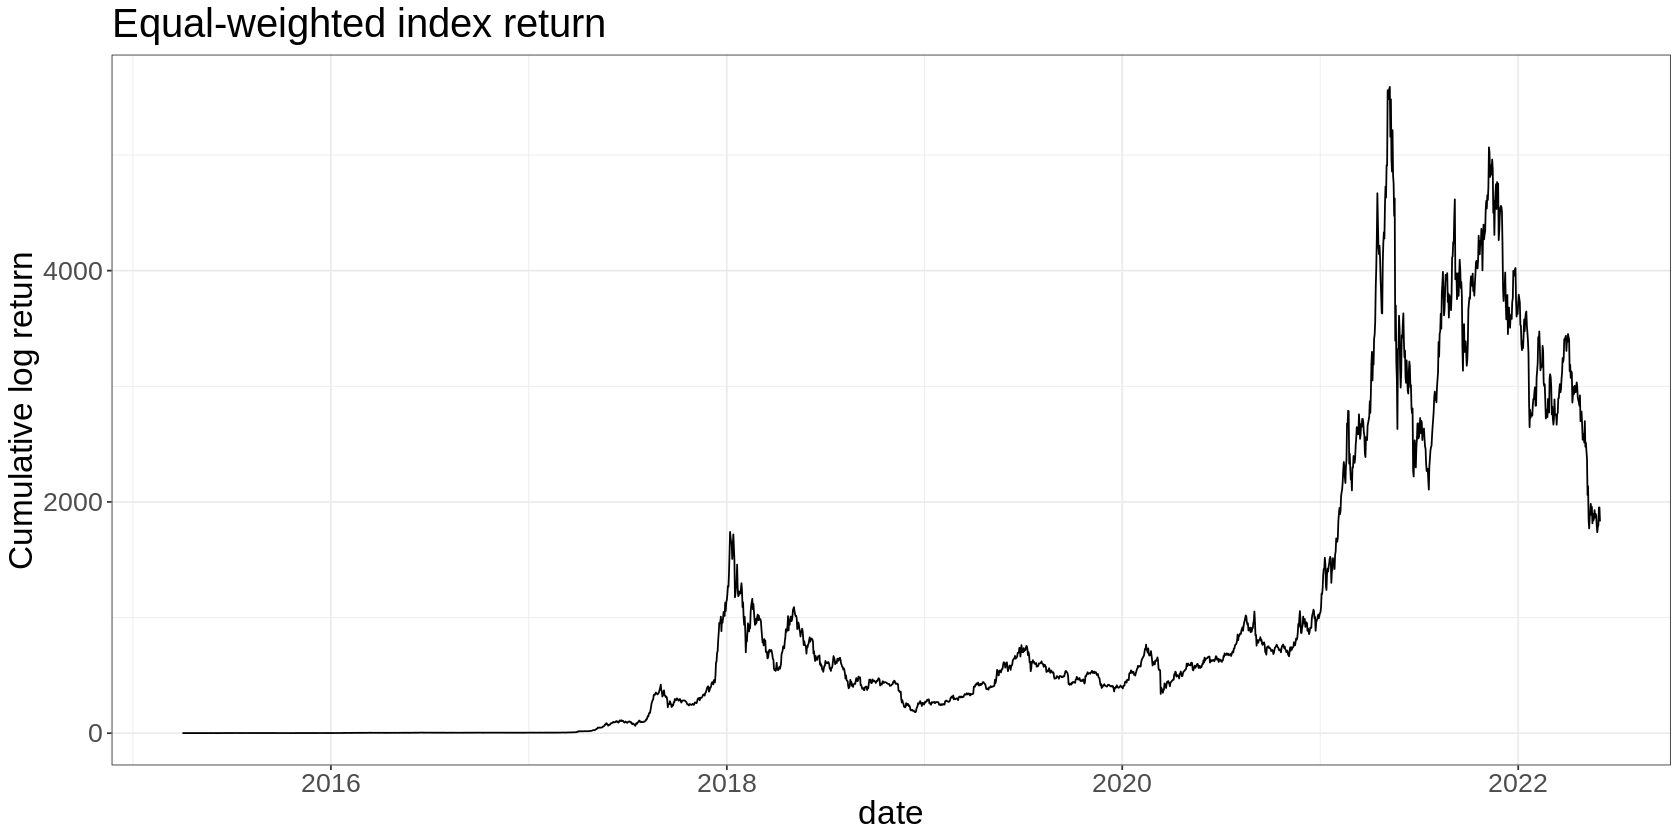

In [9]:
universe %>% 
  filter(is_index == TRUE) %>%
  arrange(date) %>%
  group_by(date) %>%
  summarise(index_return = mean(simple_return)) %>%
  mutate(cumreturn = cumprod(1+index_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) + 
    geom_line() +
    labs(
      y = "Cumulative log return",
      title = "Equal-weighted index return"
    )

Clearly, there's an upward bias to the universe.

## Factor Analysis

* Calculate weekly returns
* Standardise returns by subtracting mean returns of universe
* Is weekly relative returns predictive of future returns?
* Scatterplot
* Quintile / decile plot

### Weekly returns
Sunday to Sunday returns

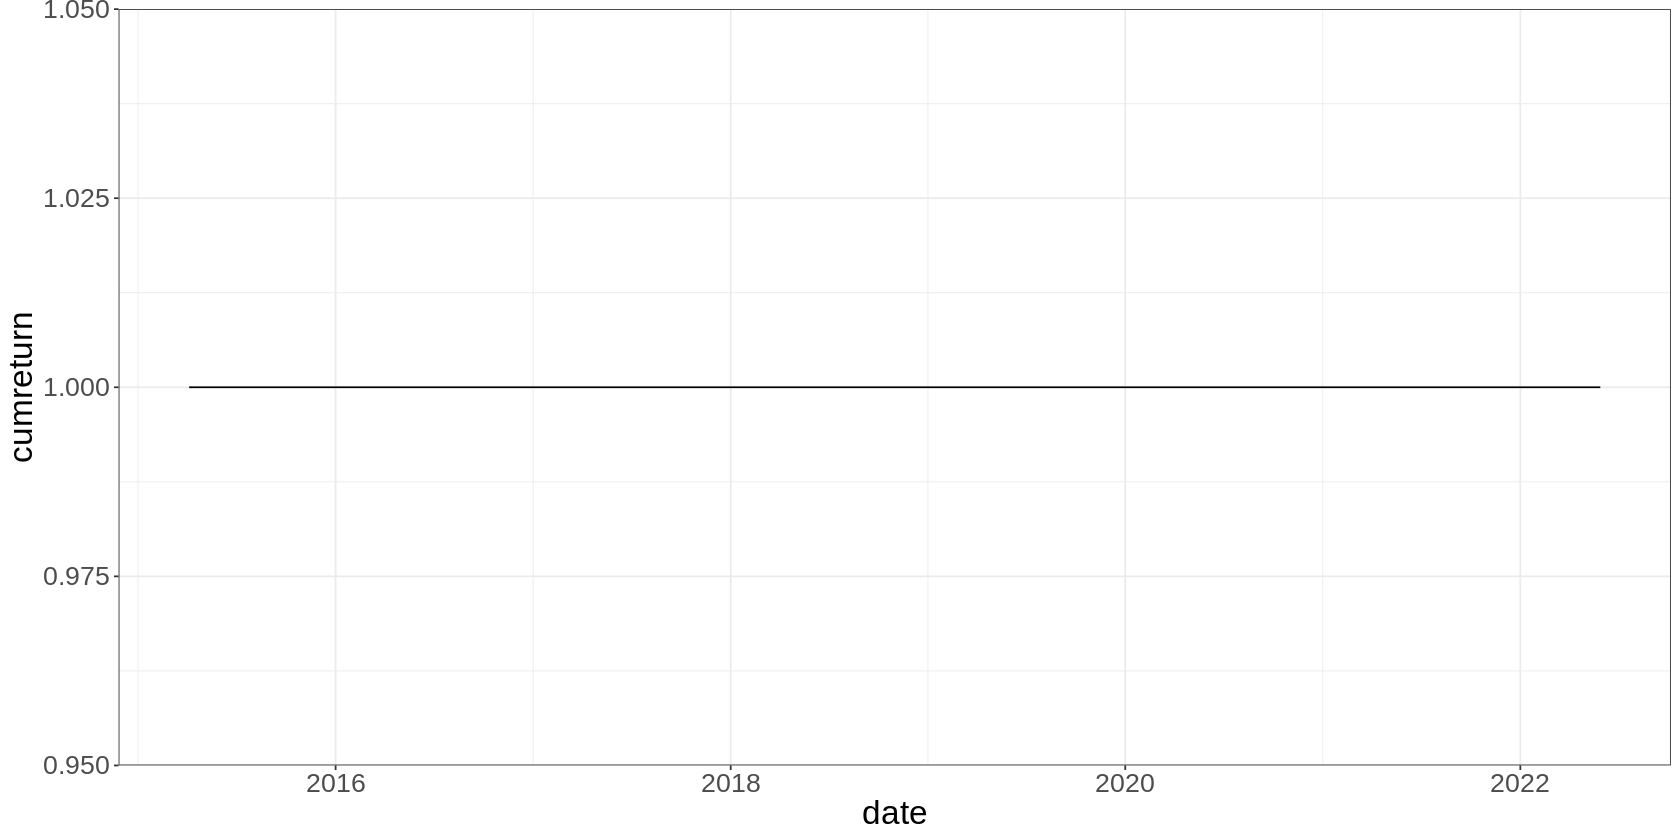

In [10]:
week_start_day <- 7  # 7 = Sunday, 1 = Monday, 2 = Tuesday, etc

# get weekly returns based on week_start_day
weekly_returns <- universe %>% 
  mutate(
    day_num = wday(date, week_start = week_start_day, label = FALSE),
    day = wday(date, week_start = week_start_day, label = TRUE)
  ) %>%
  group_by(ticker) %>%
  mutate(
    weekly_simple_return = price_usd/dplyr::lag(price_usd, n = 7) - 1,
    weekly_log_return = log(price_usd / dplyr::lag(price_usd, n = 7)),
    rolling_vol7 = roll::roll_sd(log_return, width = 7),
    weekly_risk_adjusted_return = weekly_log_return/rolling_vol7,
    month_simple_return = price_usd/dplyr::lag(price_usd, n = 30) - 1
  ) %>%
  filter(day_num == 1)

# calculate equal weighted universe return each week
index_returns <- weekly_returns %>%
  group_by(date) %>%
  filter(is_index) %>%
  summarise(
    mean_universe_return = mean(weekly_simple_return),
    mean_universe_ra_return = mean(weekly_risk_adjusted_return)
  )

# create demeaned return: weekly simple return less mean universe return
# won't have a demeaned return where we had too few tickers to create an index
# will have a demeaned return for tickers outside of index
weekly_returns <- weekly_returns %>%
  left_join(index_returns, by = "date") %>%
  mutate(
    demeaned_returns = weekly_simple_return - mean_universe_return,
    demeaned_ra_returns = weekly_risk_adjusted_return - mean_universe_ra_return
  )

# check that demeaned index return is zero
weekly_returns %>% 
  filter(is_index == TRUE) %>%
  arrange(date) %>%
  group_by(date) %>%
  summarise(index_demeaned_return = mean(demeaned_returns)) %>%
  na.omit() %>%
  mutate(cumreturn = cumprod(1+index_demeaned_return)) %>%
  ggplot(aes(x=date, y=cumreturn)) + 
    geom_line()


There are some astronomical weekly returns in both directions:

min,max
<dbl>,<dbl>
-0.6518443,5.741614


Warning message:
“Removed 33 rows containing non-finite values (`stat_bin()`).”


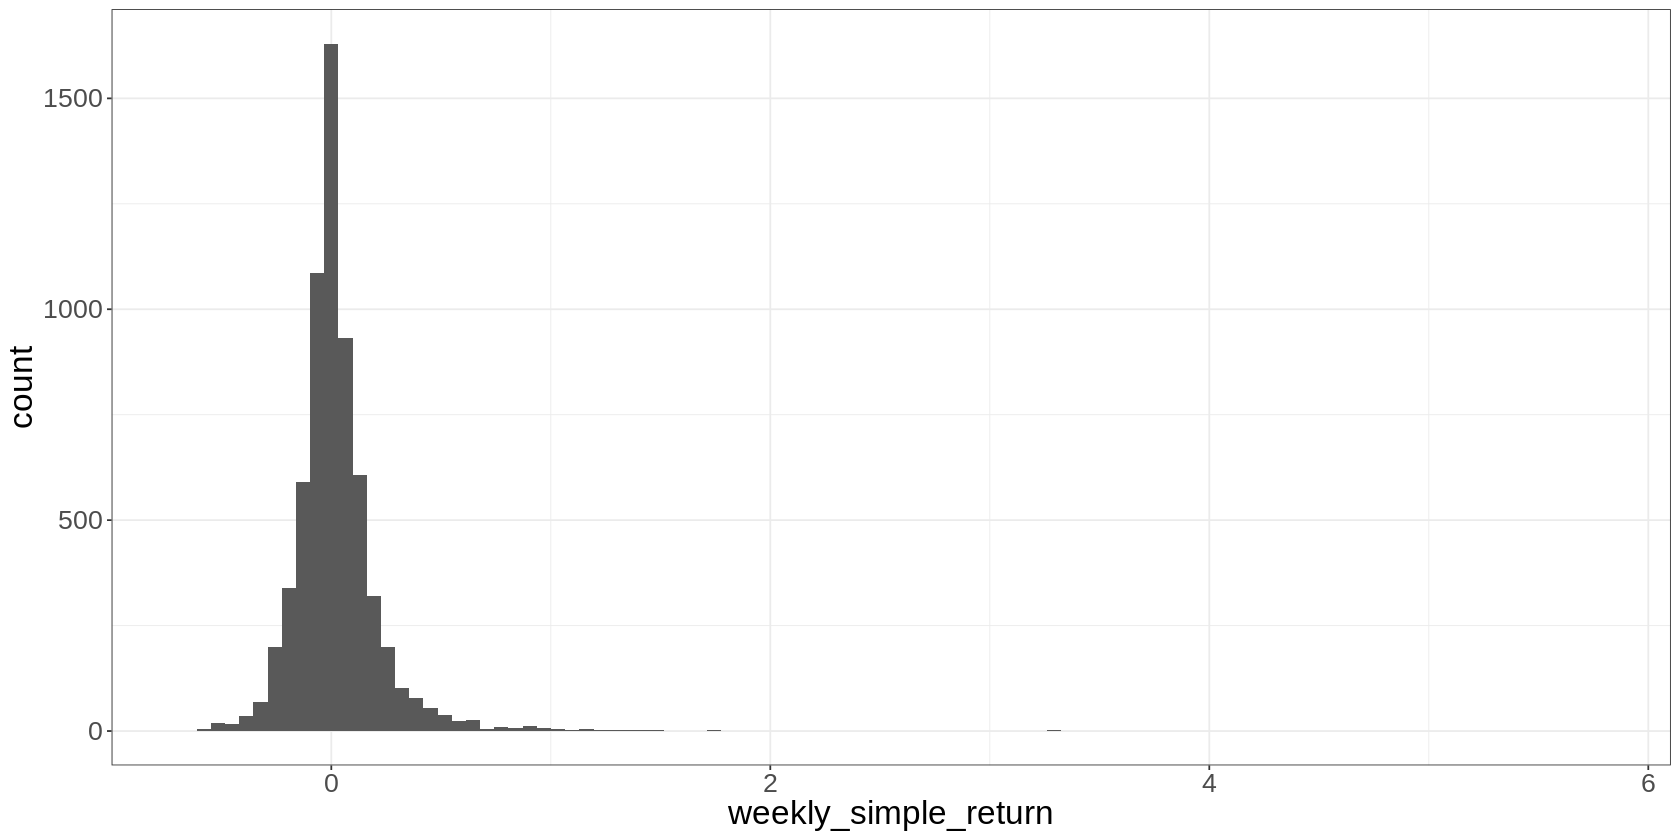

In [11]:
weekly_returns %>% 
  ungroup() %>%
  summarise(
    min = min(weekly_simple_return, na.rm = TRUE),
    max = max(weekly_simple_return, na.rm = TRUE)
  )

weekly_returns %>%
  ggplot(aes(x = weekly_simple_return)) +
    geom_histogram(bins = 100)

Also in our index:

min,max
<dbl>,<dbl>
-0.5365215,5.741614


Warning message:
“Removed 15 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 119 rows containing non-finite values (`stat_bin()`).”


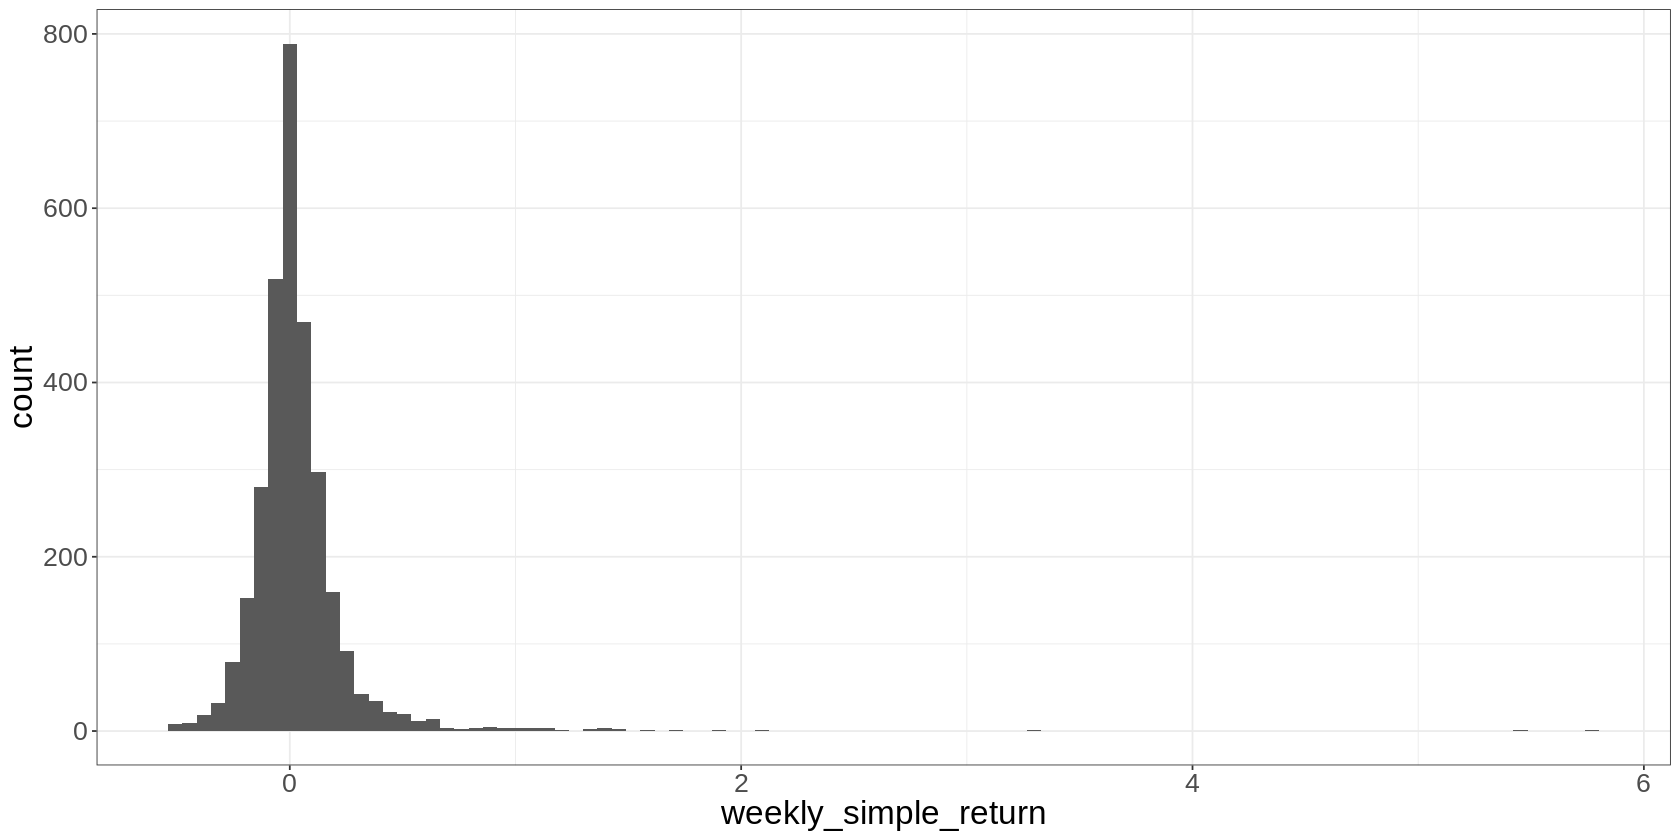

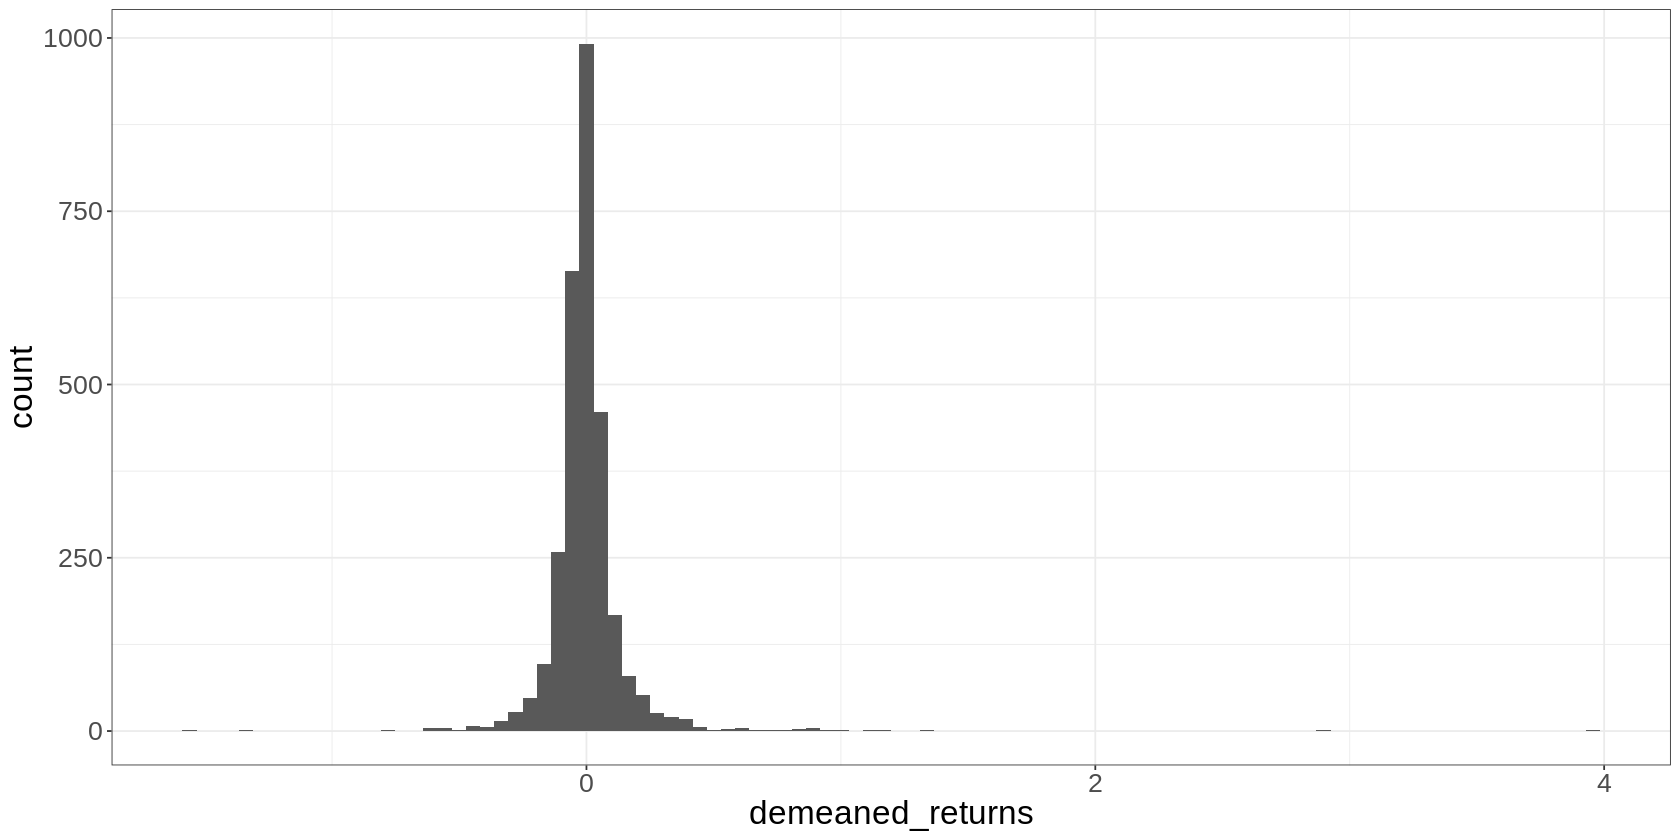

In [12]:
weekly_returns %>% 
  ungroup() %>%
  filter(is_index == TRUE) %>%
  summarise(
    min = min(weekly_simple_return, na.rm = TRUE),
    max = max(weekly_simple_return, na.rm = TRUE)
  )

weekly_returns %>%
  filter(is_index == TRUE) %>%
  ggplot(aes(x = weekly_simple_return)) +
    geom_histogram(bins = 100)

weekly_returns %>%
  filter(is_index == TRUE) %>%
  ggplot(aes(x = demeaned_returns)) +
    geom_histogram(bins = 100)

### Are weekly relative returns predictive of future returns?

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 225 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 225 rows containing missing values (`geom_point()`).”


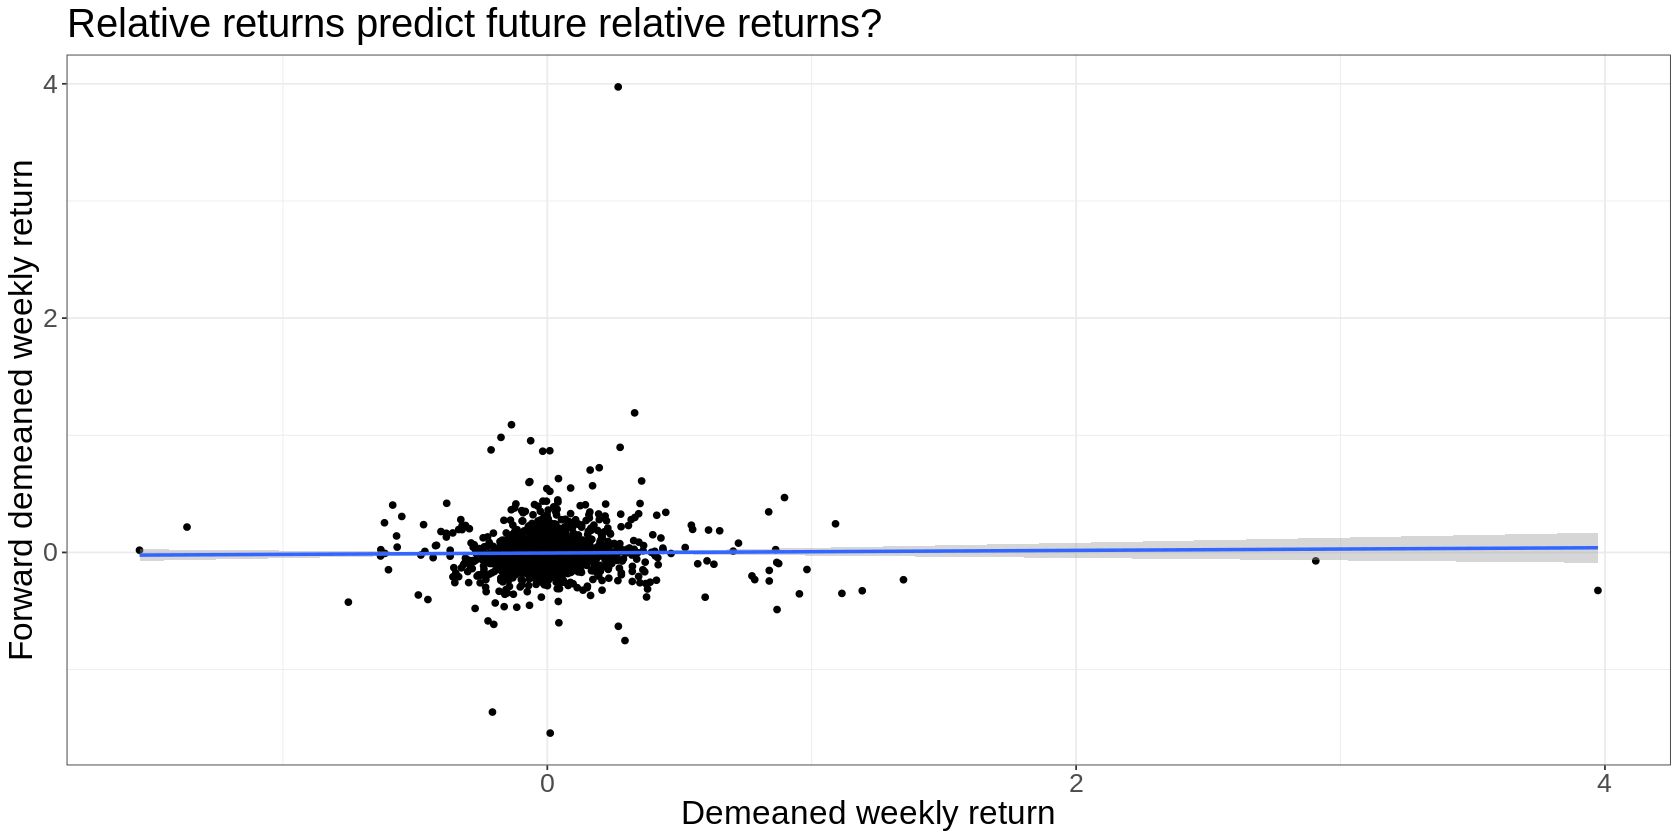

In [13]:
weekly_returns <- weekly_returns %>% 
  group_by(ticker) %>%
  mutate(
    fwd_simple_return = dplyr::lead(weekly_simple_return, n = 1),
    fwd_log_return = dplyr::lead(weekly_log_return, n = 1),
    fwd_demeaned_returns = dplyr::lead(demeaned_returns, n = 1)
  ) 

weekly_returns %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  ggplot(aes(x = demeaned_returns, y = fwd_demeaned_returns)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(
      x = "Demeaned weekly return",
      y = "Forward demeaned weekly return",
      title = "Relative returns predict future relative returns?"
    )

Let's reduce our data, by plotting the mean de-meaned returns for each different ranks. 

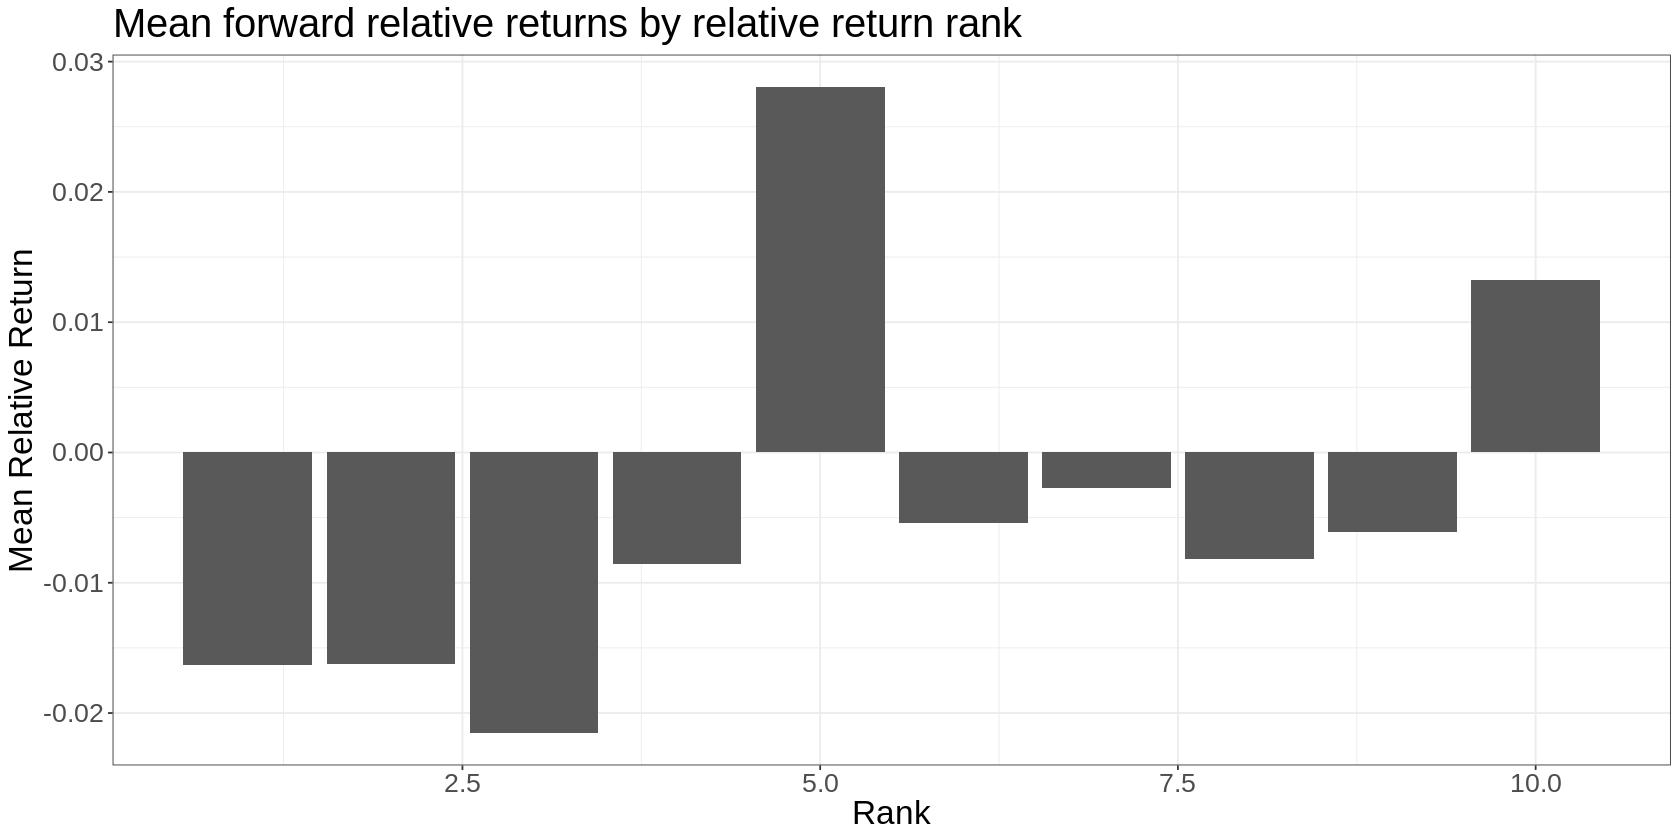

In [14]:
weekly_returns %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(rank) %>%
  summarise(mean_weekly_relative_return = mean(fwd_demeaned_returns, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_relative_return)) +
    geom_bar(stat = "identity") +
    labs(
      x = "Rank",
      y = "Mean Relative Return",
      title = "Mean forward relative returns by relative return rank"
    )

Now the mean log returns.

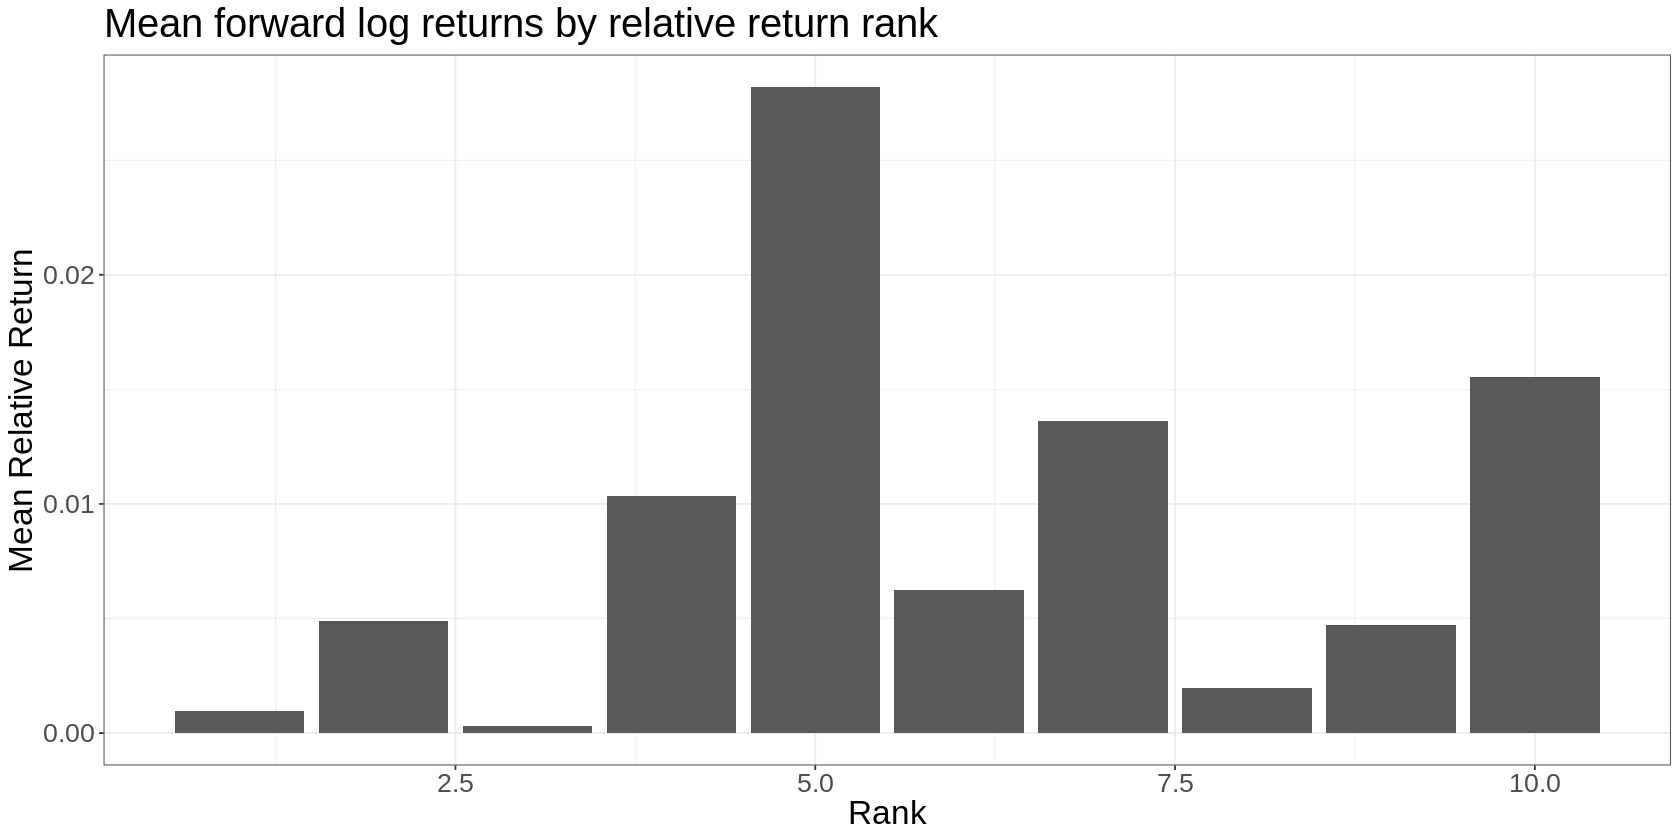

In [15]:
weekly_returns %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(rank) %>%
  summarise(mean_weekly_log_return = mean(fwd_log_return, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_log_return)) +
    geom_bar(stat = "identity") +
    labs(
      x = "Rank",
      y = "Mean Relative Return",
      title = "Mean forward log returns by relative return rank"
    )

Let's look for each year...

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


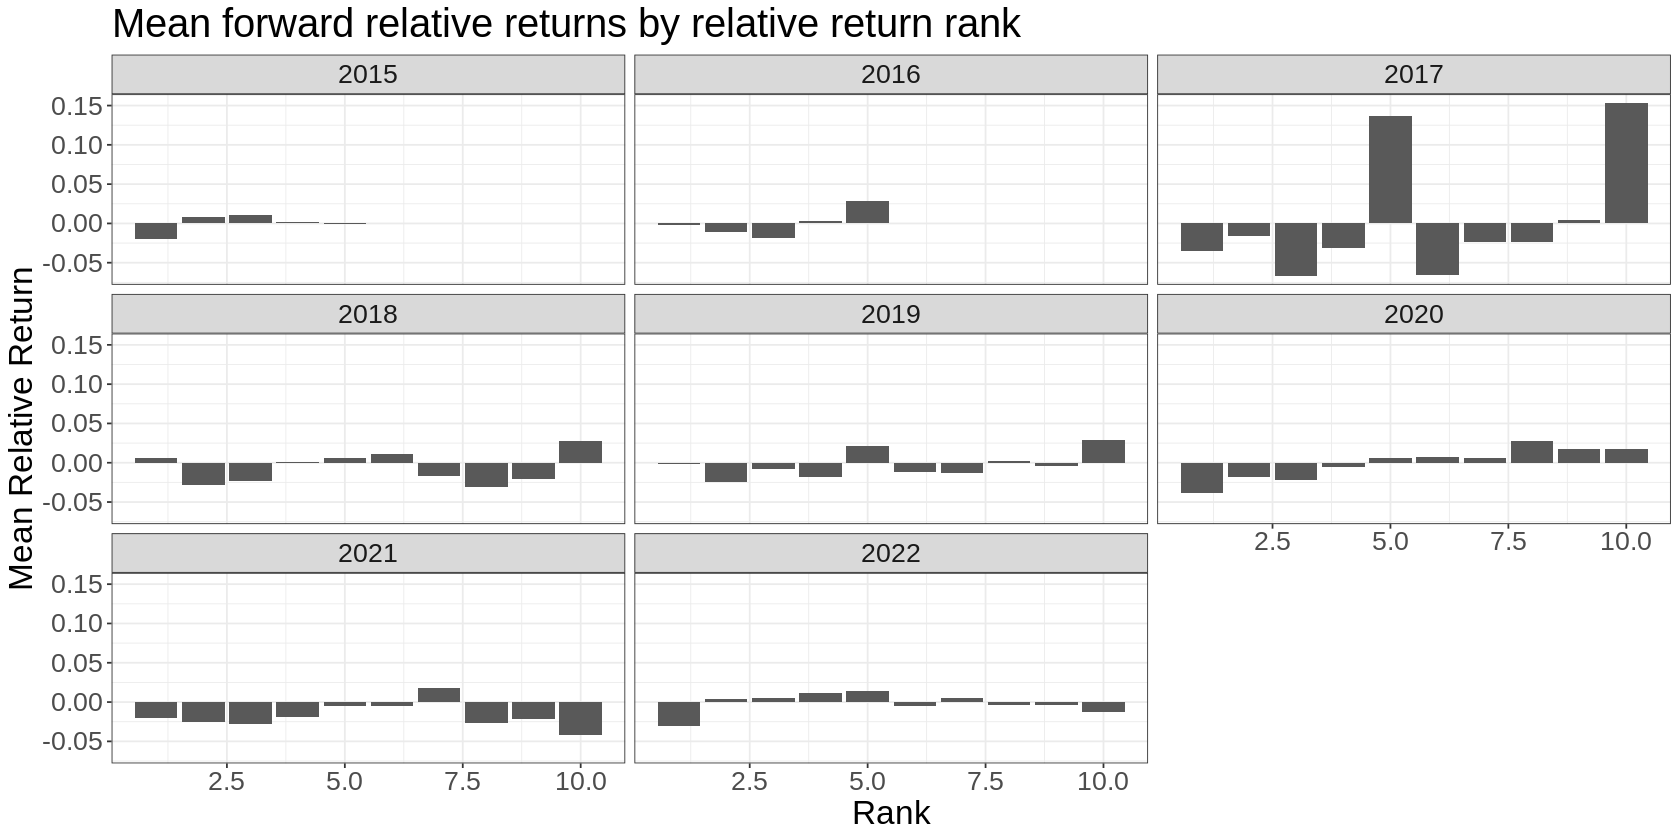

In [16]:
weekly_returns %>%
  mutate(year = year(date)) %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(year, rank) %>%
  summarise(mean_weekly_relative_return = mean(fwd_demeaned_returns, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_relative_return)) +
    geom_bar(stat = "identity") +
    labs(
      x = "Rank",
      y = "Mean Relative Return",
      title = "Mean forward relative returns by relative return rank"
    ) + 
    facet_wrap(~year)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


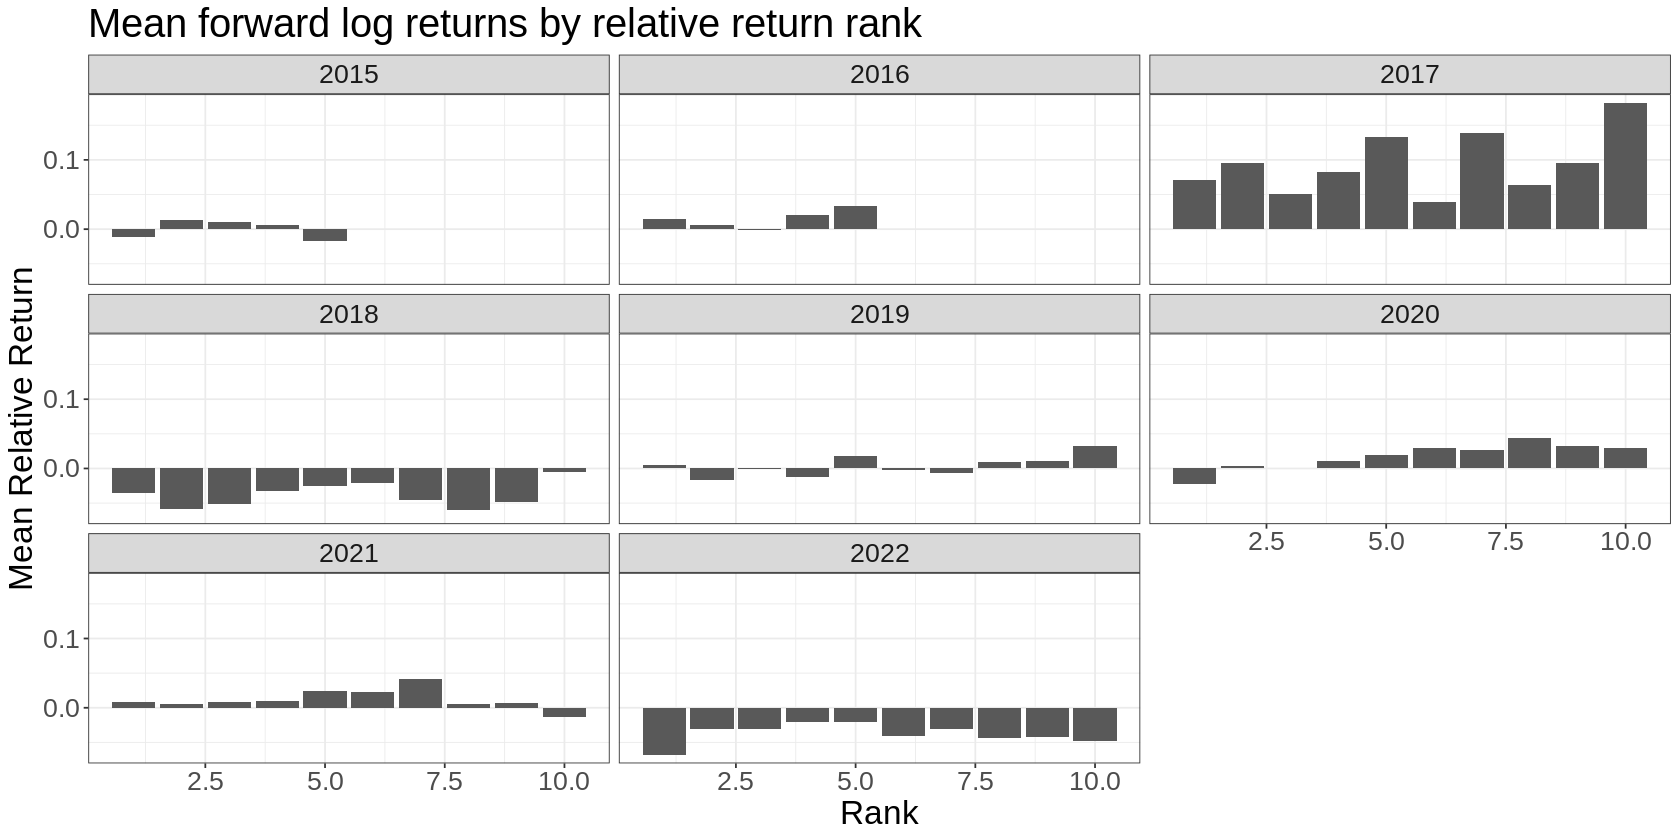

In [17]:
weekly_returns %>%
  mutate(year = year(date)) %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(year, rank) %>%
  summarise(mean_weekly_log_return = mean(fwd_log_return, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_log_return)) +
    geom_bar(stat = "identity") +
    labs(
      x = "Rank",
      y = "Mean Relative Return",
      title = "Mean forward log returns by relative return rank"
    ) + 
     facet_wrap(~year)

# Things to look at
* Time series momentum filter (we've seen the market tends to show trend effects)
* A wider universe
* Is a risk-adjusted return measure more effective (removing jumpy stuff)

# TSMOM filter

`summarise()` has grouped output by 'TSMOM'. You can override using the
`.groups` argument.


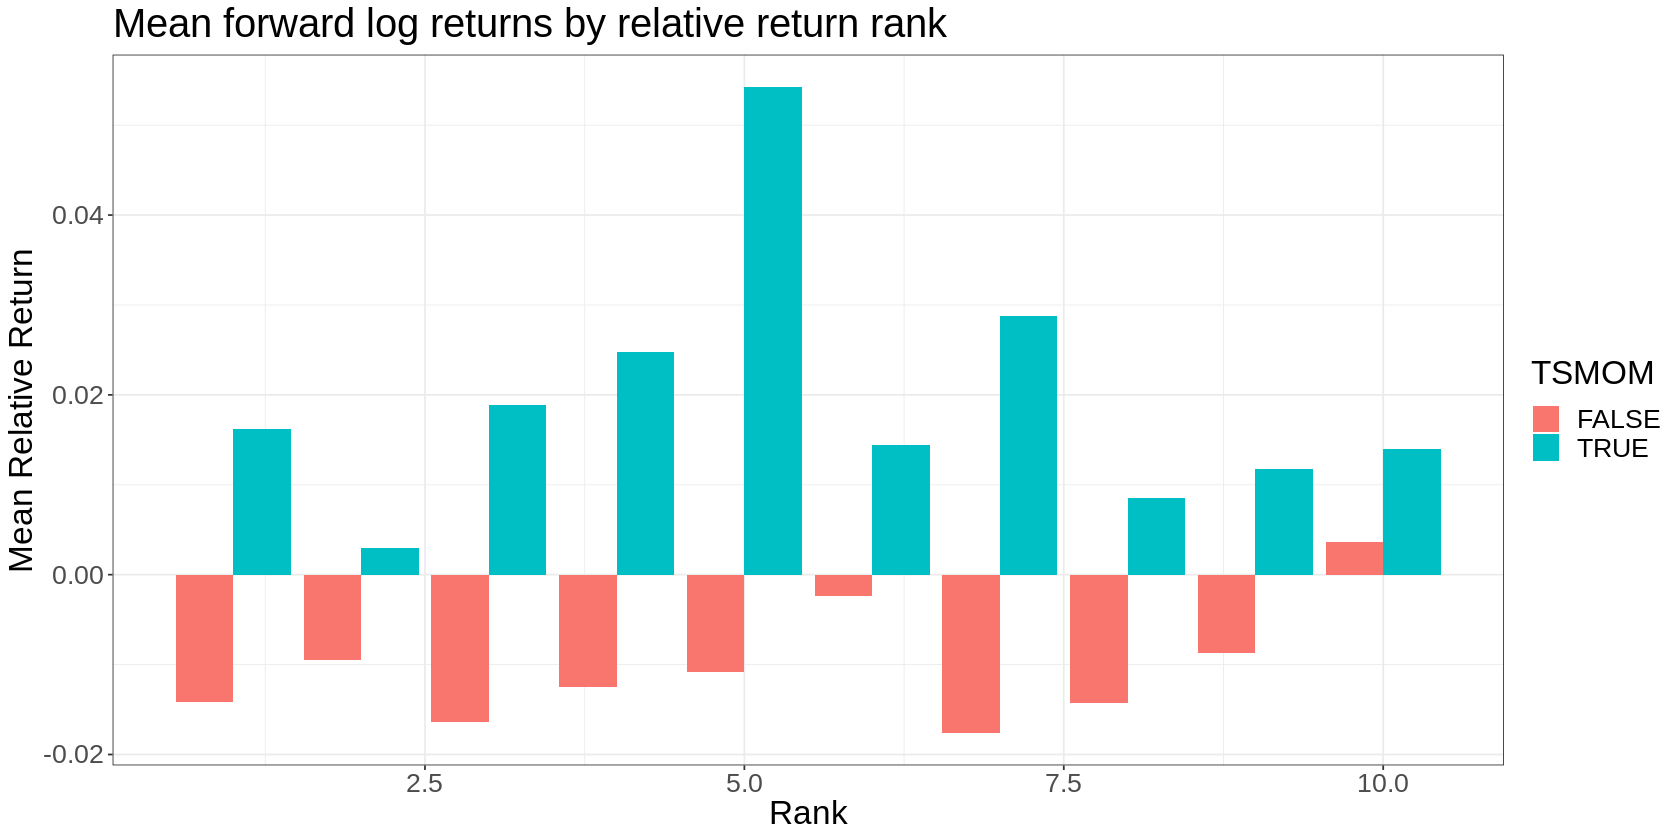

In [18]:
weekly_returns %>% 
  na.omit() %>%
  mutate(
    TSMOM = month_simple_return >= 0, 
    year= year(date)
  ) %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(TSMOM, rank) %>%
  summarise(mean_weekly_log_return = mean(fwd_log_return, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_log_return, fill = TSMOM)) +
    geom_bar(stat = "identity", position = 'dodge') +
    labs(
      x = "Rank",
      y = "Mean Relative Return",
      title = "Mean forward log returns by relative return rank"
    )


By year?

`summarise()` has grouped output by 'TSMOM', 'year'. You can override using the
`.groups` argument.


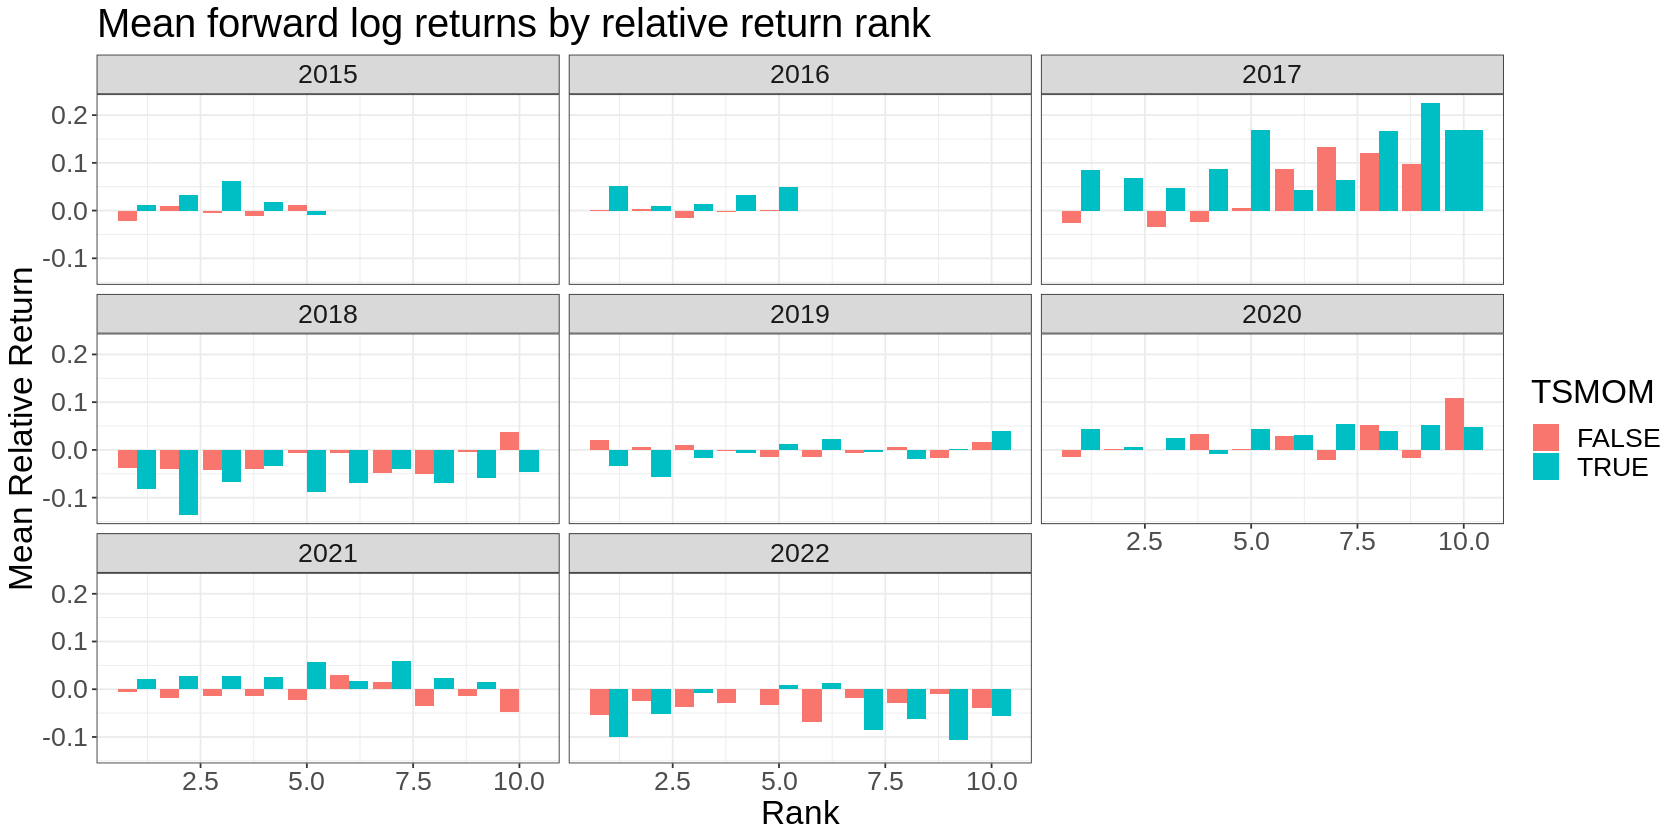

In [19]:
weekly_returns %>% 
  na.omit() %>%
  mutate(
    TSMOM = month_simple_return >= 0, 
    year= year(date)
  ) %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(TSMOM, year, rank) %>%
  summarise(mean_weekly_log_return = mean(fwd_log_return, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_log_return, fill = TSMOM)) +
    geom_bar(stat = "identity", position = 'dodge') +
    labs(
      x = "Rank",
      y = "Mean Relative Return",
      title = "Mean forward log returns by relative return rank"
    ) + facet_wrap(~year)

# Dumb "Backtest" 

Universe of top 10 coins by market cap
Hold the top 2 by weekly momentum, if TSMOM over past 30 days is positive.



Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


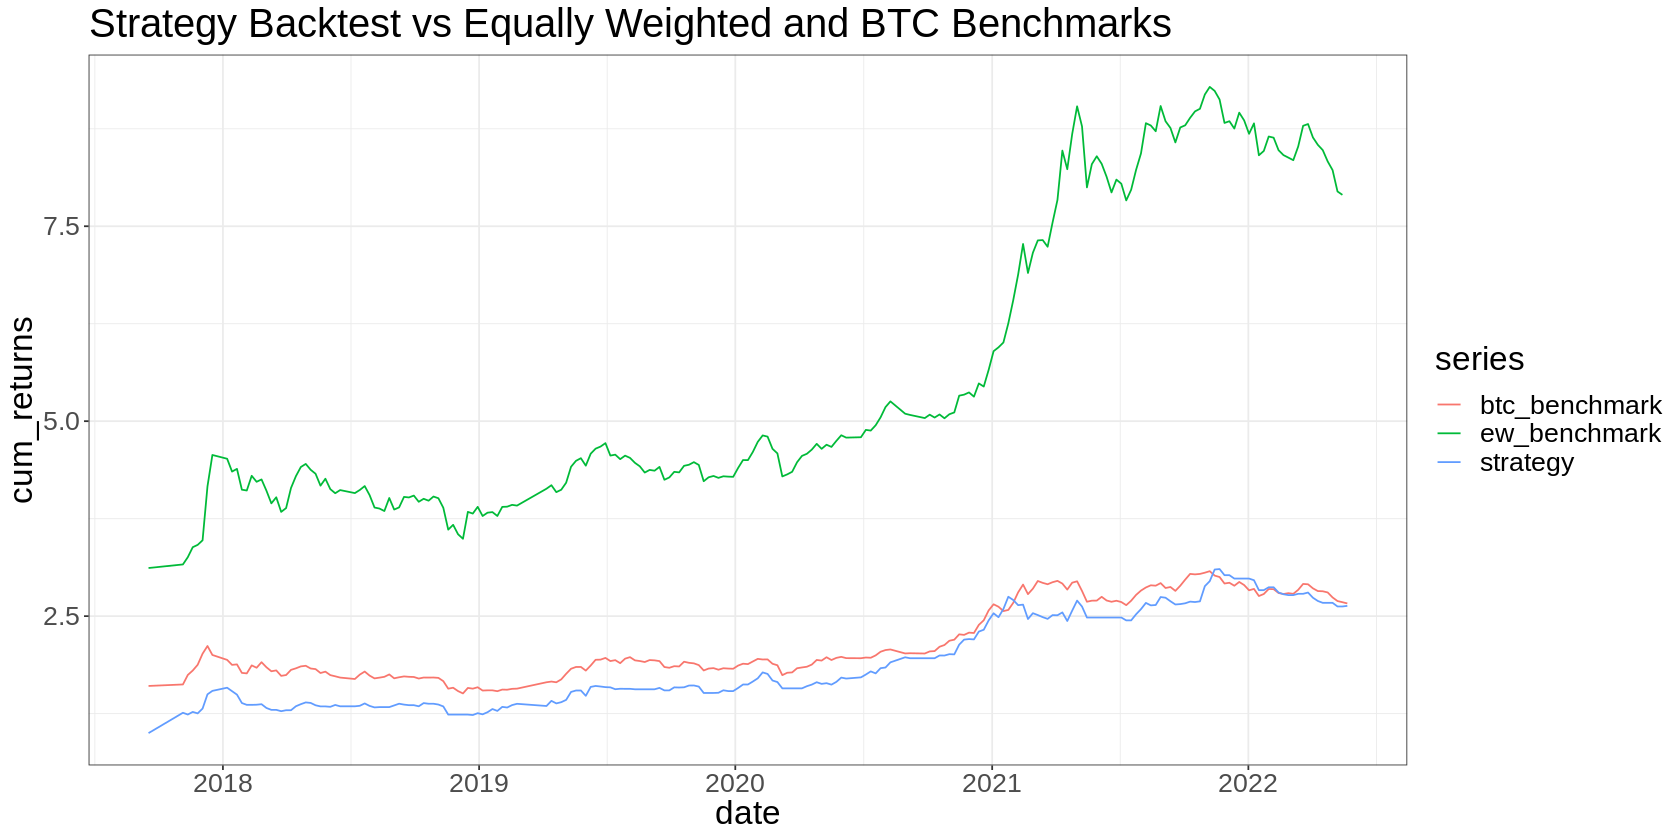

In [20]:
sizing_multiplier <- 0.2

strategy_returns <- weekly_returns %>% 
  na.omit() %>%
  mutate(
    TSMOM = month_simple_return >= 0, 
    year= year(date)
  ) %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_returns) %>%
  mutate(rank = row_number()) %>% 
  filter(rank >= 9) %>%
  mutate(strategy_return = case_when(TSMOM ~ fwd_simple_return, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarise(strategy_return = mean(strategy_return)) %>%
  mutate(strategy = cumprod(1+(sizing_multiplier * strategy_return)))


benchmark_returns <- weekly_returns %>%
  na.omit() %>%
  filter(ticker == 'BTC') %>%
  mutate(ew_benchmark_return = dplyr::lead(mean_universe_return ,1),
         btc_benchmark_return = fwd_simple_return) %>%
  mutate(ew_benchmark = cumprod(1+(sizing_multiplier * ew_benchmark_return)),
         btc_benchmark = cumprod(1+(sizing_multiplier* btc_benchmark_return)))



strategy_returns %>%
  inner_join(benchmark_returns, by = 'date') %>%
  pivot_longer(c('strategy', 'ew_benchmark', 'btc_benchmark'), names_to = 'series', values_to = 'cum_returns') %>%
  ggplot(aes(x=date, y=cum_returns, color = series)) +
    geom_line() +
    ggtitle('Strategy Backtest vs Equally Weighted and BTC Benchmarks')

# Next Steps

* Check that effect persists to different universe definitions
* Dig into the two momentum effects - look at stability over timescales, parameters etc
* Look at cost optimization

### Look at Risk Adjusted Returns

Use risk-adjusted returns instead in order to remove jumpy observations

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 225 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 225 rows containing missing values (`geom_point()`).”


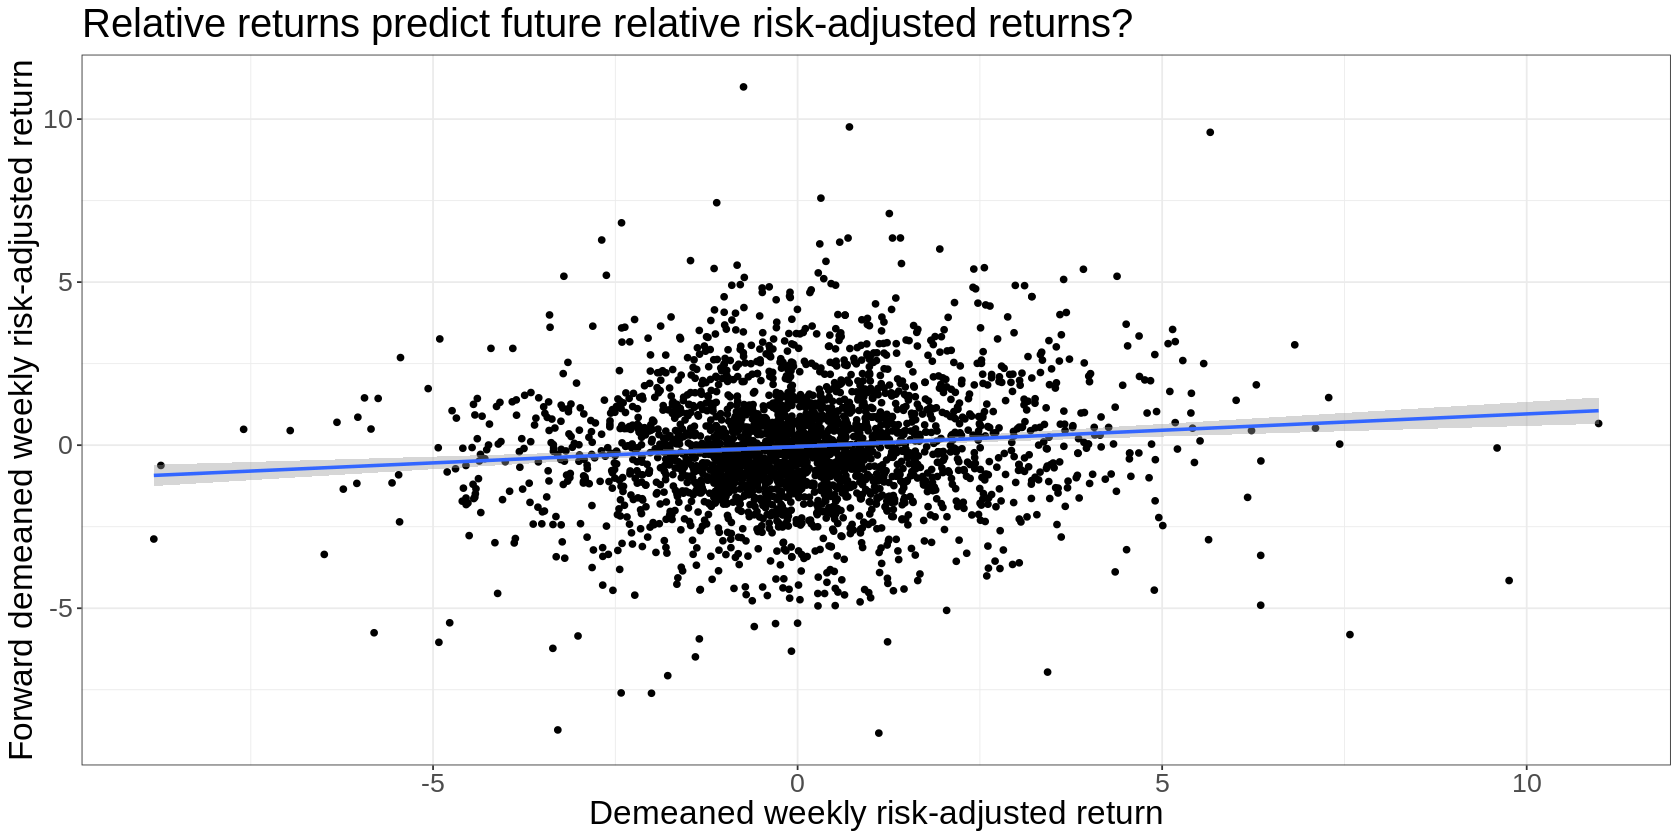

In [21]:
weekly_ra_returns <- weekly_returns %>% 
  group_by(ticker) %>%
  mutate(
    fwd_ra_return = dplyr::lead(weekly_risk_adjusted_return, n = 1),
    fwd_log_return = dplyr::lead(weekly_log_return, n = 1),
    fwd_demeaned_ra_returns = dplyr::lead(demeaned_ra_returns, n = 1)
  ) 

weekly_ra_returns %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  ggplot(aes(x = demeaned_ra_returns, y = fwd_demeaned_ra_returns)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(
      x = "Demeaned weekly risk-adjusted return",
      y = "Forward demeaned weekly risk-adjusted return",
      title = "Relative returns predict future relative risk-adjusted returns?"
    )

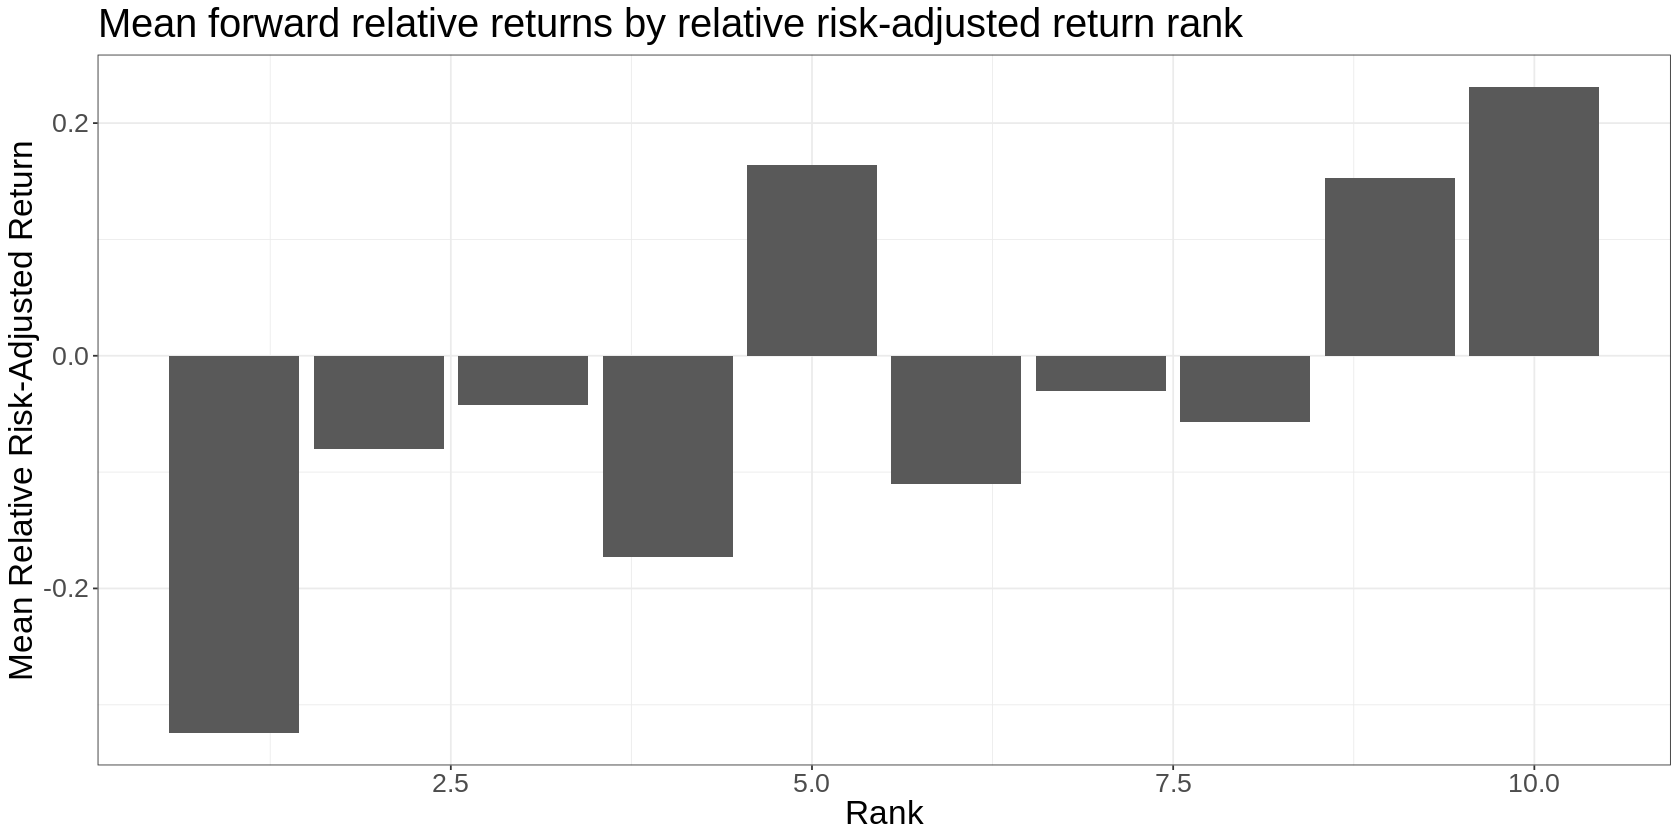

In [22]:
weekly_ra_returns %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_ra_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(rank) %>%
  summarise(mean_weekly_relative_ra_return = mean(fwd_demeaned_ra_returns, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_relative_ra_return)) +
    geom_bar(stat = "identity") +
    labs(
      x = "Rank",
      y = "Mean Relative Risk-Adjusted Return",
      title = "Mean forward relative returns by relative risk-adjusted return rank"
    )

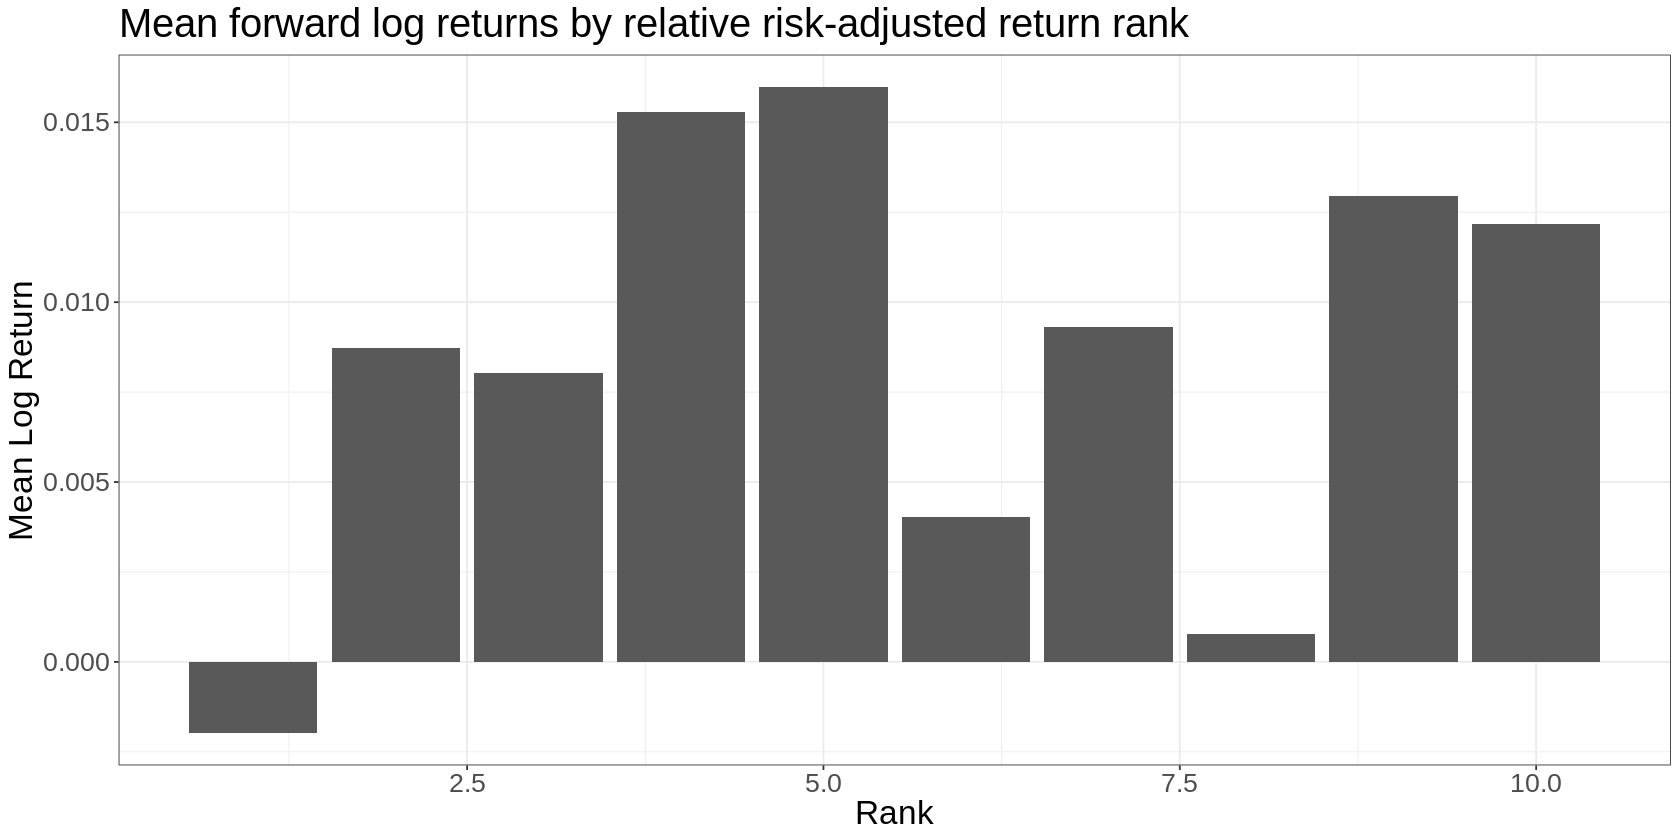

In [23]:
weekly_ra_returns %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_ra_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(rank) %>%
  summarise(mean_weekly_log_return = mean(fwd_log_return, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_log_return)) +
    geom_bar(stat = "identity") +
    labs(
      x = "Rank",
      y = "Mean Log Return",
      title = "Mean forward log returns by relative risk-adjusted return rank"
    )

By year:

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


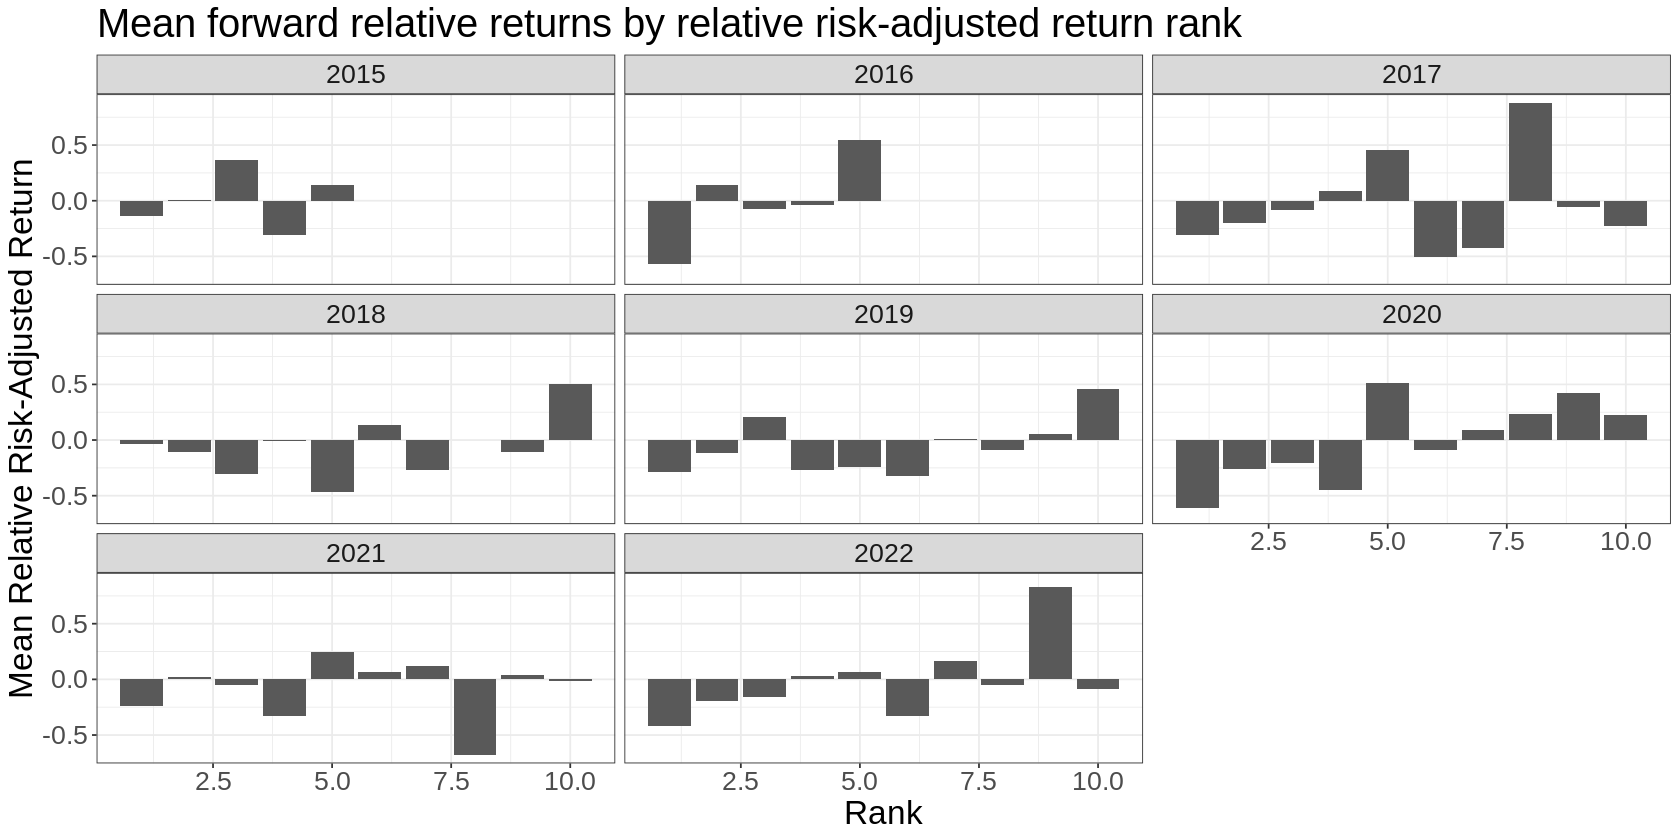

In [24]:
weekly_ra_returns %>%
  mutate(year = year(date)) %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_ra_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(year, rank) %>%
  summarise(mean_weekly_relative_ra_return = mean(fwd_demeaned_ra_returns, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_relative_ra_return)) +
    geom_bar(stat = "identity") +
    labs(
      x = "Rank",
      y = "Mean Relative Risk-Adjusted Return",
      title = "Mean forward relative returns by relative risk-adjusted return rank"
    ) + 
    facet_wrap(~year)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


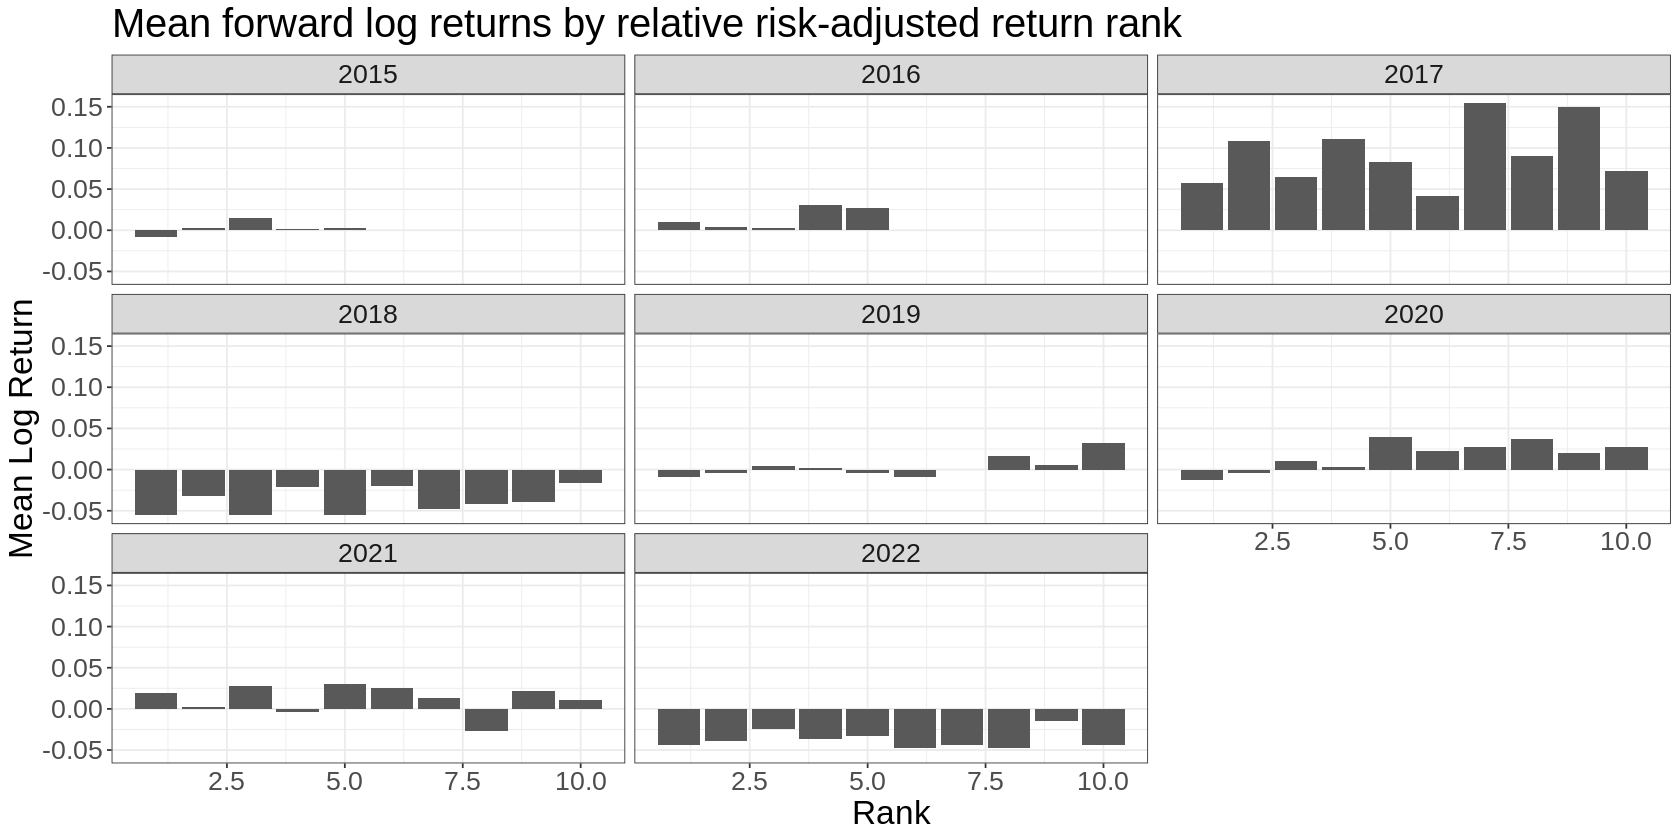

In [25]:
weekly_ra_returns %>%
  mutate(year = year(date)) %>%
  # NOTE: filter on index after calculating returns
  filter(is_index == TRUE) %>%
  # group by date and rank
  group_by(date) %>%
  arrange(demeaned_ra_returns) %>%
  mutate(
    rank = row_number()
  ) %>% 
  # summarise by relative return rank
  group_by(year, rank) %>%
  summarise(mean_weekly_log_return = mean(fwd_log_return, na.rm = TRUE)) %>%
  # plot
  ggplot(aes(x = rank, y = mean_weekly_log_return)) +
    geom_bar(stat = "identity") +
    labs(
      x = "Rank",
      y = "Mean Log Return",
      title = "Mean forward log returns by relative risk-adjusted return rank"
    ) + 
    facet_wrap(~year)